### Machine learning: Tercera parte

Vamos a crear un modelo de sistema de recomendación, pero antes vamos a realizar un EDA a los datos.

### Análisis exploratorio de los datos.


Antes de realizar el modelo de machine learning, vamos a verificar las columnas involucradas.
Columnas userId, rating_y y id.


In [1]:

# Importamos las librerías necesarias. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from deta import Deta
from deta import Drive
import gc #garbage collector

sns.set()


In [5]:
#Nos conectamos a la base de datos alojada en Deta Drive.
# Iteramos para guardar espacio en el disco
deta = Deta("e0t3zaGELWHa_JjY9Bw5uJusD698dB1Qxqujkpo3h3SQy")
drive = deta.Drive("data")
large_file = drive.get('data.csv')
with open("data.csv", "wb+") as f:
  for chunk in large_file.iter_chunks(4096):
      f.write(chunk)
  large_file.close()

In [2]:
#Leemos el archivo
df_ML = pd.read_csv('./Streamlit/data.csv',usecols=["userId","rating_y","id",'title','type'], compression='gzip')
df_ML.head()


,type,title,id,userId,rating_y
0,movie,dick johnson is dead,ns1,64,4.5
1,movie,dick johnson is dead,ns1,189,3.5
2,movie,dick johnson is dead,ns1,212,2.5
3,movie,dick johnson is dead,ns1,261,4.0
4,movie,dick johnson is dead,ns1,303,3.5


In [3]:
#Filtramos solo las peliculas
df_ML = df_ML[df_ML['type']=='movie']
#Convertimos las demás columnas
df_ML['userId'] = df_ML['userId'].astype(int)
df_ML['id'] = df_ML['id'].astype(str)
df_ML['rating_y'] = df_ML['rating_y'].astype(float)


gc.collect()

0

In [4]:
#Dado que ya tenemos las peliculas, ya no necesitamos la columna type.
df_ML.drop('type',axis= 1, inplace= True)
df_ML.shape

(7897251, 4)

In [5]:
#Cantidad de usuarios unicos
print(len(df_ML['userId'].unique()))

114301


In [6]:
# Calificaciones de películas por usuario
df_by_users = df_ML.groupby(['userId']).count()
df_by_users.head()

,title,id,rating_y
userId,,,
1,17,17,17
2,11,11,11
3,8,8,8
4,48,48,48
5,17,17,17


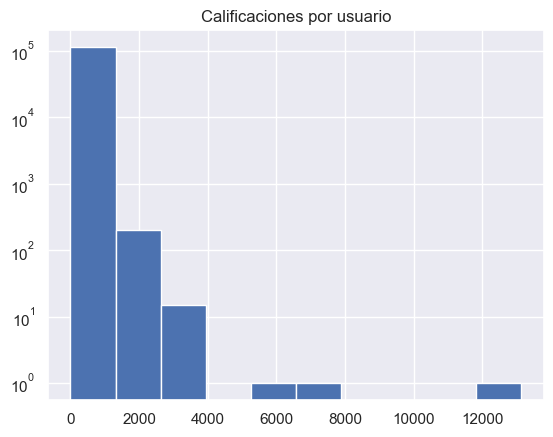

In [7]:
plt.hist(df_by_users.rating_y, log= True)
plt.title('Calificaciones por usuario')
plt.show()

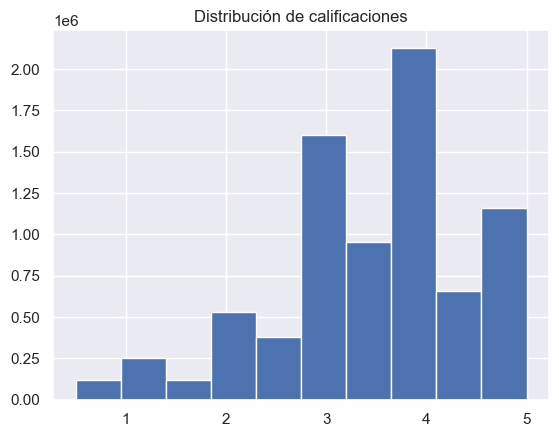

In [8]:
# Observamos la distribución de las calificaciones

df_ML['rating_y'].hist()
plt.title('Distribución de calificaciones')
plt.show()

In [9]:
#Peliculas con mas y menos calificaciones.
df_by_movies = df_ML.groupby(['id']).count()
df_by_movies.head()
max = df_by_movies['userId'].idxmax()
print(df_ML.title[df_ML.id == max].iloc[0])

from other worlds


In [10]:
# Pelicula con menos calificaciones
min = df_by_movies['userId'].idxmin()
print(df_ML.title[df_ML.id == min].iloc[0])

mitzi (nbc 1968)


In [11]:
# 10 peliculas mas populares.
df_by_movies = df_ML.groupby(['id']).count()
df_by_movies.sort_values('userId', ascending = False, inplace = True)
df_by_movies['Vistos'] = df_by_movies['userId']
df_by_movies.drop(columns = ['userId','rating_y','title'], inplace = True)

In [12]:
df_by_movies = pd.merge(df_by_movies,df_ML[['id','title']], on='id', how='inner')
df_by_movies.drop_duplicates( keep = 'first',inplace=True)
df_by_movies.head(10)

,id,Vistos,title
0,as4197,576,from other worlds
576,as9065,560,the organization
1136,ns7279,558,"leapfrog: sing-along, read-along"
1694,as9469,556,all good things
2250,as6998,556,sideways
2806,hs582,554,battle over britney: the conservatorship hearing
3360,as4889,554,a stone in the water
3914,ns1847,553,el-khawaga's dilemma
4467,ds552,552,national treasure
5019,ns5992,552,14 cameras


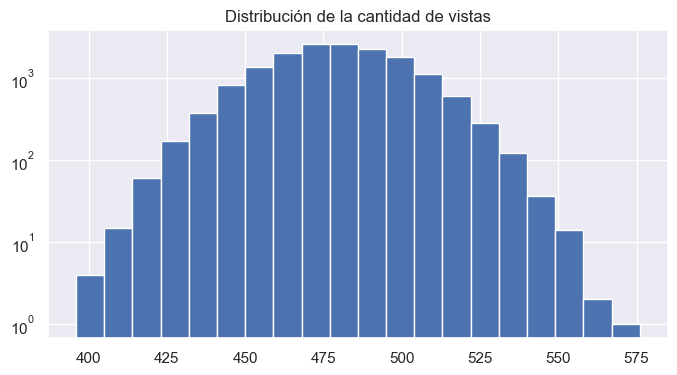

In [13]:
#Distribucion de la cantidad de vistos
plt.figure(figsize = (8,4))
df_by_movies.Vistos.hist(log = True, bins = 20)
plt.title('Distribución de la cantidad de vistas')
plt.show()

### Machine learning

In [14]:
#Trabajaremos con la libreria surprise.
# pip install scikit-surprise, instalando previamente windows build tools 17.
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import Dataset

In [15]:
df_ML.shape

(7897251, 4)

In [16]:
df_ML.userId.head()

0     64
1    189
2    212
3    261
4    303
Name: userId, dtype: int32

In [17]:
df_ML.id.head()

0    ns1
1    ns1
2    ns1
3    ns1
4    ns1
Name: id, dtype: object

In [18]:
reader = Reader()

In [19]:
df_ML2 = df_ML.copy()


In [20]:
values = np.unique(df_ML2['id'])

In [21]:
new_id = pd.DataFrame(values, index = np.arange(1,len(values)+1))

In [22]:
new_id.rename(columns={0:'id'},inplace=True)

In [23]:
new_id

,id
1,as1
2,as10
3,as100
4,as1000
5,as1001
...,...
16477,ns993
16478,ns995
16479,ns996
16480,ns997


In [24]:
#Creamos la nueva columna.
new_id['newid'] = new_id.index


In [25]:
auxtable = new_id.merge(df_ML[['id','title']], on = 'id', how = 'left')
auxtable.drop_duplicates(inplace= True)

In [26]:
#Guardamos esta tabla para trabajar con ella en Streamlit.
#La subimos al drive.

auxtable.to_csv('data_aux.csv')

In [27]:
#Realizamos un merge, para poner el nuevo id en mi vieja tabla.
dataframe = df_ML.merge(new_id[['id','newid']], on = 'id', how = 'left')


In [28]:
#Guardamos tambien esta tabla para trabajar con ella en Streamlit.
dataframe.to_csv('new_data.csv', compression = 'gzip')

El dataset tiene 7897251 filas. 

In [69]:
N_filas = 100000 # Limitamos el dataset

data = Dataset.load_from_df(dataframe[['userId', 'newid', 'rating_y']][:N_filas], reader)

In [70]:
# Separamos nuestros datos
trainset, testset = train_test_split(data, test_size=.3)

In [71]:
# Usaremos un modelo de Singular Value Decomposition

from surprise import SVD
model = SVD(n_factors=5) #Según búsqueda de gridsearch

In [72]:
# Entrenamos el modelo
model.fit(trainset)

In [73]:
# Predecimos
predictions = model.test(testset)

In [74]:
predictions[1]

Prediction(uid=3347, iid=10770, r_ui=3.5, est=3.3631342153469213, details={'was_impossible': False})

In [76]:
model.predict(212,18)

Prediction(uid=212, iid=18, r_ui=None, est=3.4217270292385775, details={'was_impossible': False})

### Evaluación del modelo

In [77]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.0412


1.041191993177895

In [83]:
#Tomamos un usuario de la tabla para hacerle una recomendación
userId = 122406
rating = 4   # Tomamos películas a las que haya calificado con 4 o 5 estrellas

if userId in dataframe['userId']:
    df_user = dataframe[(dataframe['userId'] == userId) & (dataframe['rating_y'] >= rating)]
    df_user = df_user.reset_index(drop=True)


In [84]:

df_user

,title,id,userId,rating_y,newid
0,beethoven,ns326,122406,4.0,11974
1,cousins,ns427,122406,5.0,12646
2,the beguiled,ns446,122406,4.5,12792
3,the sum of all fears,ns609,122406,4.5,14043
4,wanted,ns633,122406,4.5,14258
...,...,...,...,...,...
89,how to play baseball,ds541,122406,4.5,8501
90,miracle landing on the hudson,ds1087,122406,4.5,7887
91,return to oz,ds1164,122406,4.0,7960
92,tugboat mickey,ds1393,122406,4.5,8177


In [102]:
tabla_peliculas = auxtable[['title','newid']]
print(tabla_peliculas.shape)
tabla_peliculas.head()

(16481, 2)


,title,newid
0,the grand seduction,1
502,david's mother,2
1015,wilder napalm,3
1445,sinbad: make me wanna holla,4
1930,simple gifts: the chamber music society at sha...,5


In [103]:
#Peliculas vistas por el usuario:

# Debemos extraer las películas que ya ha visto

vistas_usuario = dataframe[dataframe['userId'] == userId]
print(vistas_usuario.shape)
vistas_usuario.head()

(153, 5)


,title,id,userId,rating_y,newid
76638,the loud house movie,ns250,122406,3.5,11446
97298,beethoven,ns326,122406,4.0,11974
133452,cousins,ns427,122406,5.0,12646
139067,the beguiled,ns446,122406,4.5,12792
189738,the sum of all fears,ns609,122406,4.5,14043


In [113]:
#Realizamos un merge y luego un drop, para quedarnos con las peliculas que no vio. 
peliculas_usuario = pd.merge(tabla_peliculas,vistas_usuario , how='outer', indicator=True)
peliculas_usuario

In [117]:
peliculas_del_usuario = peliculas_usuario.loc[peliculas_usuario._merge == 'left_only', ['newid','title']]

In [118]:
# Estimamos el score que ese usuario daria a las peliculas que no vio.
peliculas_del_usuario['Estimate_Score'] = peliculas_del_usuario['newid'].apply(lambda x: model.predict(userId, x).est)
peliculas_del_usuario = peliculas_del_usuario.sort_values('Estimate_Score', ascending=False)
print(peliculas_del_usuario.head(10))

       newid                                title  Estimate_Score
11812  11813                      chennai express        4.173480
10580  10581           barbie big city big dreams        4.170831
11679  11680                 la diosa del asfalto        4.154647
10775  10776              love don't cost a thing        4.141693
11152  11153  once upon a time in mumbai dobaara!        4.123719
11502  11503                     o kadhal kanmani        4.042763
16405  16406                       paradise hills        4.032146
11927  11928  shiny_flakes: the teenage drug lord        4.021375
11419  11420                          man in love        4.012823
10921  10922                        the interview        4.001587


In [121]:
#Para saber si recomendamos o no una pelicula, vamos a considerar un umbral de 4.
#x<4 NO recomendamos
#x>4 SI recomendamos

#Filtramos
peliculas_del_usuario_filtradas = peliculas_del_usuario[peliculas_del_usuario['Estimate_Score']>4]

In [122]:
peliculas_del_usuario_filtradas

,newid,title,Estimate_Score
11812,11813,chennai express,4.173480
10580,10581,barbie big city big dreams,4.170831
11679,11680,la diosa del asfalto,4.154647
10775,10776,love don't cost a thing,4.141693
11152,11153,once upon a time in mumbai dobaara!,4.123719
11502,11503,o kadhal kanmani,4.042763
16405,16406,paradise hills,4.032146
11927,11928,shiny_flakes: the teenage drug lord,4.021375
11419,11420,man in love,4.012823
10921,10922,the interview,4.001587


In [140]:
score = peliculas_del_usuario_filtradas[peliculas_del_usuario_filtradas['title'] == 'chennai express']
score = score['Estimate_Score']
score = np.array(score)
type(score)
score = float(score)
score

4.1734799206229445

In [123]:
peliculas_del_usuario_filtradas.shape

(10, 3)

In [124]:
#Vamos a sacar el numero de factors, mediante gridsearch.

from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [125]:
# Observamos performance del mejor modelo
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0352476446014158
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


El parámetro óptimo según GridSearch es 5.
Lo modificamos arriba.